In [1]:
%reload_kedro

2020-03-10 13:28:03,930 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-03-10 13:28:03,931 - root - INFO - Defined global variable `context` and `catalog`


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Data

Computing inertia to improve $k$ with the elbow rule is time consuming and can't really get automated. Increasing $k$ according to the data needs to be done differently. We will focus on dynamic method with a fixed $k$ for now. 

In [4]:
dictionary = catalog.load("UN_dictionary")
token2id = dictionary.token2id

2020-03-10 13:28:04,132 - kedro.io.data_catalog - INFO - Loading data from `UN_dictionary` (DictionaryDataSet)...


In [5]:
BOW_train=catalog.load("BOW_train")
BOW_train

2020-03-10 13:28:04,215 - kedro.io.data_catalog - INFO - Loading data from `BOW_train` (ScipySparseMatrix)...


<5256x12459 sparse matrix of type '<class 'numpy.int64'>'
	with 2965958 stored elements in Compressed Sparse Row format>

In [99]:
BOW_train.getrow(55).data.sum()

657

In [6]:
timestamp_train = catalog.load("timestamp_train")
timestamp_train.head()

2020-03-10 13:28:04,332 - kedro.io.data_catalog - INFO - Loading data from `timestamp_train` (CSVLocalDataSet)...


,timeslice
0,20
1,24
2,23
3,29
4,39


For more interpretability, we have disabed bigrams, which weren't very valuable in the outputs of this method.

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

In [8]:
tfidf = TfidfTransformer().fit_transform(BOW_train)

In [9]:
import pickle

In [10]:
def top_terms(num_clusters, n_terms, id2token, order_centroids):
    top_terms = []*num_clusters
    for i in range(num_clusters):
        cluster_terms = []
        for ind in order_centroids[i,:n_terms]:
            cluster_terms.append(id2token[ind])
        top_terms.append(cluster_terms)
    return top_terms

# K-means : year by year

In [11]:
from tqdm import tqdm

In [12]:
n_terms = 5
num_clusters = 10

cluster_terms = []

km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == 0].index])
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

cluster_terms.append(top_terms(num_clusters, n_terms, dictionary, order_centroids))

for i in tqdm(range(1,timestamp_train.max().values[0] + 1)):
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids, n_init=1)
    km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == i].index])
    centroids = km.cluster_centers_
    order_centroids = centroids.argsort()[:,::-1]
    
    cluster_terms.append(top_terms(num_clusters, n_terms, dictionary, order_centroids))

100%|██████████| 45/45 [00:07<00:00,  5.91it/s]


In [13]:
for i in range(44):
    print(cluster_terms[i][8])

['sentiment', 'wrath', 'depleted', 'sadc', 'perpetrated']
['ideologically', 'malnourished', 'harare', 'il', 'manpower']
['ideologically', 'malnourished', 'purview', 'wrath', 'bali']
['strenuously', 'abort', 'subsided', 'legitimately', 'deposit']
['distributed', 'credibly', 'versus', 'hesitant', 'flourishing']
['gilbert', 'myriad', 'produced', 'jewish', 'reopen']
['lasting', 'furthering', 'medicine', 'extended', 'podium']
['lasting', 'geographically', 'domingo', 'medicine', 'accordingly']
['befallen', 'relegate', 'frequency', 'wherever', 'installed']
['boycotted', 'perpetrator', 'magic', 'engineering', 'convince']
['boycotted', 'magic', 'perpetrator', 'engineering', 'righteousness']
['boycotted', 'magic', 'intercourse', 'perpetrator', 'readily']
['disarm', 'subsidiary', 'primarily', 'verde', 'alleviating']
['opinion', 'imply', 'abusive', 'geographically', 'abrogation']
['imply', 'abusive', 'geographically', 'endowment', 'accordingly']
['imply', 'abusive', 'accordingly', 'inf', 'geograph

Clustering year by year isn't effective, as the previous years have the same weight as a single document of the current year. The clusters change too drastically and don't have any link from a year to another.

Instead, we add years one by one until all the data is included, while keeping the means initialized where the previous clusters were.

# K-means : additive method

In [14]:
n_terms = 5
num_clusters = 10

In [15]:
cluster_terms = []

km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == 0].index])
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

cluster_terms.append(top_terms(num_clusters, n_terms, dictionary, order_centroids))

for i in tqdm(range(1,timestamp_train.max().values[0] + 1)):
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids, n_init=1)
    km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] <= i].index])
    centroids = km.cluster_centers_
    order_centroids = centroids.argsort()[:,::-1]
    
    cluster_terms.append(top_terms(num_clusters, n_terms, dictionary, order_centroids))

100%|██████████| 45/45 [17:22<00:00, 23.17s/it]


In [16]:
pickle.dump(cluster_terms, open( "all_nogram.p", "wb" ))

In [17]:
cluster_terms = pickle.load(open( "all_nogram.p", "rb" ))

In [18]:
for i in range(44):
    print(cluster_terms[i][8])

['limitation', 'writ', 'obsessed', 'proactive', 'astonishing']
['affliction', 'flourishing', 'limitation', 'proactive', 'normality']
['flourishing', 'affliction', 'calmly', 'limitation', 'proactive']
['flourishing', 'calmly', 'affliction', 'proactive', 'fool']
['flourishing', 'calmly', 'fool', 'limitation', 'grappling']
['flourishing', 'calmly', 'fool', 'grappling', 'proactive']
['flourishing', 'calmly', 'fool', 'inf', 'grappling']
['flourishing', 'calmly', 'inf', 'fool', 'grappling']
['flourishing', 'calmly', 'inf', 'fool', 'grappling']
['flourishing', 'calmly', 'inf', 'fool', 'grappling']
['flourishing', 'inf', 'calmly', 'fool', 'grappling']
['flourishing', 'inf', 'calmly', 'grappling', 'fool']
['flourishing', 'inf', 'calmly', 'grappling', 'fool']
['flourishing', 'inf', 'calmly', 'grappling', 'fool']
['flourishing', 'inf', 'calmly', 'grappling', 'fool']
['flourishing', 'inf', 'calmly', 'grappling', 'fool']
['flourishing', 'inf', 'calmly', 'grappling', 'ethically']
['flourishing', 'in

This method seems to detect strong changes but isn't very flexible. Let's use a slinding window.

# K-means : sliding window

In [19]:
def inbetween(i, timestamp_train, w_size):
    return timestamp_train[timestamp_train['timeslice'] <= i][timestamp_train['timeslice'] > i-w_size].index

In [ ]:
w_size = 10

cluster_terms = []

km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == 0].index])
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

cluster_terms.append(top_terms(num_clusters, n_terms, dictionary, order_centroids))

for i in tqdm(range(1,timestamp_train.max().values[0] + 1)):
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids, n_init=1)
    if i>w_size-1:
        km.fit(tfidf[inbetween(i, timestamp_train, w_size)])
    else:
        km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] <= i].index])
    centroids = km.cluster_centers_
    order_centroids = centroids.argsort()[:,::-1]
    
    cluster_terms.append(top_terms(num_clusters, n_terms, dictionary, order_centroids))

For w_size=5, we get the following clusters :

In [21]:
pickle.dump(cluster_terms, open( "wsize5_nogram.p", "wb" ))

In [22]:
cluster_terms = pickle.load(open( "wsize5_nogram.p", "rb" ))

In [23]:
for i in range(44):
    print(cluster_terms[i][9])

['limitation', 'grappling', 'escape', 'healthy', 'militarist']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['grappling', 'limitation', 'escape', 'invested', 'healthy']
['concept', 'understands', 'obliterate', 'grappling', 'derail']
['bedevilled', 'vessel', 'academia', 'clarified', 'page']
['bedevilled', 'vessel', 'academia', 'clarified', 'page']
['bedevilled', 'vessel', 'academia', 'clarified', 'page']
['bedevilled', 'vessel', 'academia', 'clarified', 'page']
['bedevilled', 'vessel', 'academia', 'clarified', 'page']
['bedevilled', 'vessel', 'academia

This model is much less stable but enables to show that the sliding window allows more change in the topic meaning. However, we can see that the global topic meaning strongly changed.

With w_size = 10, we get :

In [24]:
pickle.dump(cluster_terms, open( "wsize10_nogram.p", "wb" ))

In [25]:
cluster_terms = pickle.load(open( "wsize10_nogram.p", "rb" ))

In [26]:
for i in range(44):
    print(cluster_terms[i][8])

['calmly', 'tum', 'cannon', 'stifled', 'invoking']
['tum', 'calmly', 'stifled', 'invoking', 'enumerate']
['calmly', 'tum', 'stifled', 'invoking', 'frequency']
['calmly', 'tum', 'cannon', 'stifled', 'invoking']
['calmly', 'tum', 'cannon', 'stifled', 'invoking']
['calmly', 'tum', 'cannon', 'stifled', 'invoking']
['calmly', 'cannon', 'tum', 'stifled', 'invoking']
['calmly', 'cannon', 'tum', 'stifled', 'invoking']
['cannon', 'calmly', 'tum', 'stifled', 'invoking']
['cannon', 'calmly', 'stifled', 'tum', 'negligence']
['cannon', 'stifled', 'calmly', 'tum', 'frequency']
['cannon', 'stifled', 'frequency', 'tum', 'calmly']
['cannon', 'stifled', 'tum', 'negligence', 'frequency']
['cannon', 'stifled', 'tum', 'negligence', 'frequency']
['cannon', 'stifled', 'tum', 'negligence', 'frequency']
['cannon', 'stifled', 'vice', 'negligence', 'tum']
['cannon', 'vice', 'stifled', 'frequency', 'negligence']
['cannon', 'stifled', 'negligence', 'followed', 'vice']
['cannon', 'stifled', 'followed', 'negligence'

In [34]:
token2id['sassou']

11868

# Topic visualisation

In [27]:
import matplotlib.pyplot as plt

In [28]:
import pickle
cluster_terms = pickle.load(open( "wsize5_nogram.p", "rb" ))

In [29]:
def print_top_terms(n_topic, n_terms, max_t, cluster_terms):
    words = []
    for x in cluster_terms:
        words.extend(x[n_topic])

    words = {e:[0] * max_t for e in set(words)}

    for i in range(max_t):
        for word in cluster_terms[i][n_topic]:
            words[word][i] = n_terms - cluster_terms[i][n_topic].index(word)

    x = range(max_t)

    plt.figure(figsize=(20,10))
    plt.xlabel("timestamps")
    plt.ylabel("words rank for topic %d"% n_topic)

    for word, ranks in words.items():
        plt.plot(x, ranks, label = word)
    plt.legend()
    plt.show()

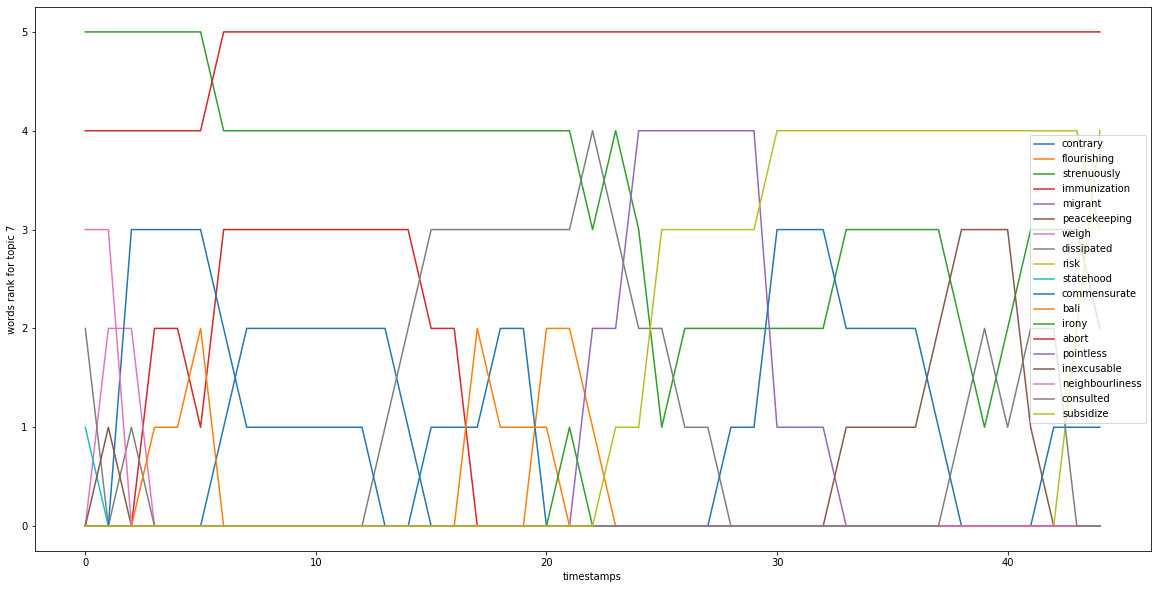

In [61]:
n_topic = 7
n_terms = 5
max_t = timestamp_train.max().values[0]

print_top_terms(n_topic, n_terms, max_t, cluster_terms)

# Word2Vec and k-means

In [35]:
import numpy as np

In [31]:
Glove_embeddings = catalog.load("Glove_embeddings")

2020-03-10 13:51:38,604 - kedro.io.data_catalog - INFO - Loading data from `Glove_embeddings` (TextEmbeddingDataset)...


In [36]:
un_embeddings = dict()

vocab_size = len(dictionary)
words_found = 0
for token_id in tqdm(range(vocab_size)):
    word = dictionary[token_id]
    try:
        un_embeddings[word] = Glove_embeddings[word]
        words_found += 1
    except KeyError:
        un_embeddings[word] = np.array([0]*300)

print("Number of words found on embedding : {} out of {}".format(words_found, vocab_size))

100%|██████████| 12459/12459 [00:00<00:00, 614042.20it/s]

Number of words found on embedding : 12422 out of 12459


In [38]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [39]:
emb_size = 300
num_clusters = 3

In [104]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(list(un_embeddings.values()))
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

In [41]:
def distances(embeddings, center):
    dists = dict()
    for word in embeddings.keys():
        dists[word] = [np.linalg.norm(embeddings[word] - center)]
    return dists

In [42]:
dists = [distances(un_embeddings, center) for center in order_centroids]

In [43]:
from seaborn import heatmap

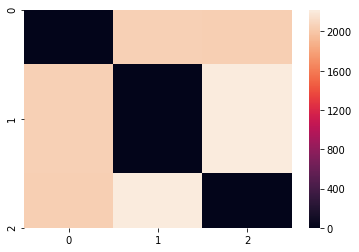

In [44]:
heatmap([[np.linalg.norm(center1 - center2) for center2 in order_centroids] for center1 in order_centroids])

In [45]:
for center in order_centroids:
    d = distances(un_embeddings, center)
    print(sorted(d, key=d.get)[:5])

['socialist', 'somali', 'boigny', 'nguema', 'pluralist']
['pseudo', 'socialist', 'melanesian', 'nguema', 'leninist']
['somali', 'graf', 'infantry', 'army', 'battalion']


In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(list(un_embeddings.values())))
points['target'] = km.labels_

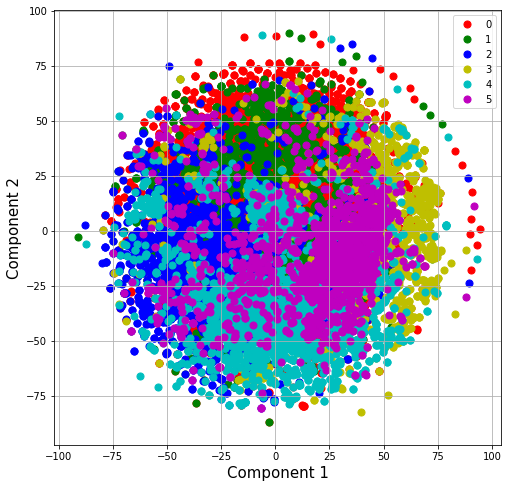

In [107]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Document embeddings and kmeans

There, we want to clusterize documents themselves, by the mean of their embeddings. We can use the previous versions of kmeans to get the same results.

In [73]:
def generate_doc_embedding_mean(doc_index, BOW, id2token, emb_size):
    doc_embedding = np.zeros((1, emb_size))
    __, cols = BOW.getrow(doc_index).nonzero()
    for word_id in cols:
        try:
            doc_embedding += Glove_embeddings[id2token[word_id]]
        except:
            pass
    return doc_embedding / BOW_train.getrow(doc_index).sum()

In [74]:
doc_embeddings = np.zeros((BOW_train.shape[0], emb_size))

for doc_index in tqdm(range(BOW_train.shape[0])):
    doc_embeddings[doc_index] = generate_doc_embedding_mean(doc_index, BOW_train, dictionary, emb_size)

100%|██████████| 5256/5256 [00:15<00:00, 344.44it/s]


In [83]:
inertie = []

for k in tqdm(range(2, 20)):
    km = KMeans(n_clusters=k, n_jobs=-1)
    km.fit(doc_embeddings)
    inertie.append(km.inertia_)

100%|██████████| 18/18 [00:18<00:00,  1.00s/it]


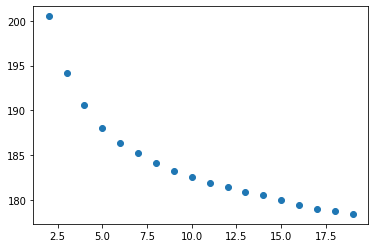

In [86]:
plt.scatter(range(2,20), inertie)

In [87]:
num_clusters = 6

In [108]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(doc_embeddings)
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

In [109]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(doc_embeddings))
points['target'] = km.labels_

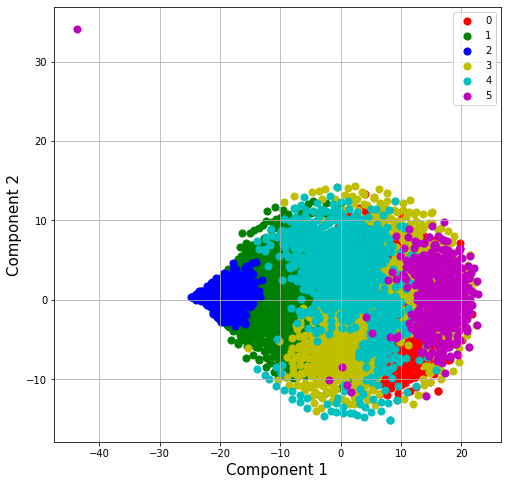

In [111]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [119]:
def generate_doc_embedding_max(doc_index, BOW, id2token, emb_size):
    doc_embedding = np.zeros((1, emb_size))
    __, cols = BOW.getrow(doc_index).nonzero()
    for word_id in cols:
        try:
            doc_embedding = np.maximum(doc_embedding, Glove_embeddings[id2token[word_id]])
        except:
            pass
    return doc_embedding

In [122]:
doc_embeddings_max = np.zeros((BOW_train.shape[0], emb_size))

for doc_index in tqdm(range(BOW_train.shape[0])):
    doc_embeddings_max[doc_index] = generate_doc_embedding_max(doc_index, BOW_train, dictionary, emb_size)

100%|██████████| 5256/5256 [00:16<00:00, 324.83it/s]


In [130]:
inertie = []

for k in tqdm(range(2, 15)):
    km = KMeans(n_clusters=k, n_jobs=-1)
    km.fit(doc_embeddings_max)
    inertie.append(km.inertia_)

100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


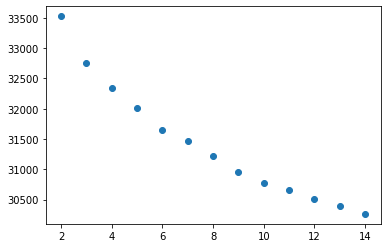

In [133]:
plt.scatter(range(2,15), inertie)

In [134]:
num_clusters = 10

In [135]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(doc_embeddings_max)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [136]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(doc_embeddings_max))
points['target'] = km.labels_

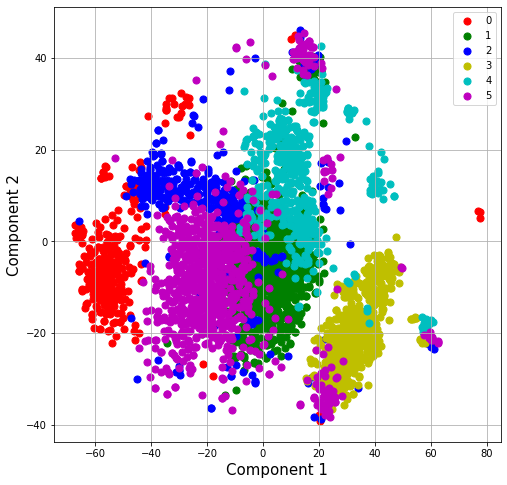

In [137]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()